# How to import Abaqus meshes

This notebook demonstrates how to import simulation results from Abaqus in pylife, e.g., to be used for a FKM nonlinear assessment.

For this notebook to run, you need an installation of Abaqus and you have to install the odbclient and odb-server.
Please refer to https://pylife.readthedocs.io/en/latest/tools/odbclient/

In [1]:
import odbclient as CL
import numpy as np
import timeit

# pylife
import pylife
import pylife.vmap
import pylife.stress.equistress
import pylife.mesh.gradient

In [2]:
### kt2-specimen, simplex mesh, 973490 nodes

## Select the location where Abaqus is installed
# The example file needs Abaqus 2020

#abaqus_bin = r"C:\Program Files\SIMULIA\2019\AbaqusCAE\win_b64\code\bin\ABQLauncher.exe"
abaqus_bin = r"C:\Program Files\SIMULIA\2020\EstProducts\win_b64\code\bin\ABQLauncher.exe"
#abaqus_bin = r"C:\Program Files\SIMULIA\2021\EstProducts\win_b64\code\bin\ABQLauncher.exe"

# load the mesh file
filename = 'data/kt1.odb'
client = CL.OdbClient(filename, abaqus_bin=abaqus_bin)

# Select and print the available instances, steps and frame_ids
instance = 'KT2-1'
instance = 'KT1-1'
step = 'Step-1'
increment = 1

print(f"instances: {client.instance_names()}")
print(f"steps: {client.step_names()}")
print(f"frames: {client.frame_ids(step)}")

variable_names = client.variable_names(step, increment)
print(f"variable names: {variable_names}")

# get the node coordinates
coordinates = client.node_coordinates(instance)

# select the stress variable
pylife_mesh = client.variable('S', instance, step, increment)

# calculate the Mises equistress
pylife_mesh['mises'] = pylife_mesh.equistress.mises()

# add the node coordinates and organize the dataframe multi-index
pylife_mesh = coordinates.join(pylife_mesh)
pylife_mesh = pylife_mesh.reorder_levels(["element_id", "node_id"])


instances: ['KT1-1']
steps: ['Step-1']
frames: [0, 1]
variable names: ['E', 'RF', 'S', 'U']


C:\Users\mbe7rng\AppData\Roaming\Python\Python39\site-packages\odbclient\odbclient.py:89: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  index=pd.Int64Index(index, name='node_id'))


In [3]:
# Calculate the stress gradient (method 1)
tstart = timeit.default_timer()
grad = pylife_mesh.gradient.gradient_of('mises')
tend = timeit.default_timer()
print(f"duration calculate stress gradient: {tend-tstart:.1f} s")

grad["abs_grad"] = np.linalg.norm(grad, axis=1)

duration calculate stress gradient: 3.0 s


In [4]:
# Calculate the stress gradient (method 2)
tstart = timeit.default_timer()
grad1 = pylife_mesh.gradient_3D.gradient_of('mises')
tend = timeit.default_timer()
print(f"duration calculate stress gradient: {tend-tstart:.1f} s")

grad1["abs_grad"] = np.linalg.norm(grad1, axis=1)
pylife_mesh = pylife_mesh.join(grad1, sort=False)

d:\pylife\src\pylife\mesh\gradient.py:384: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_grad = df.groupby("element_id").apply(self._compute_gradient)


duration calculate stress gradient: 19.8 s


Now we have successfully imported a finite element mesh from an Abaqus simulation and calculated the Mises stress and the stress gradient.

In [5]:
pylife_mesh

x         y         z         S11        S22  \
element_id node_id                                                        
1          68      -0.058024  0.005909  0.001042  107.280235  15.659771   
           95      -0.058024  0.004247  0.000926  107.280235  15.659771   
           96      -0.058024  0.003611  0.002350  107.280235  15.659771   
           58      -0.058024  0.005196  0.003000  107.280235  15.659771   
           14      -0.060000  0.005909  0.001042  107.280235  15.659771   
...                      ...       ...       ...         ...        ...   
2684       3315     0.060000 -0.000494  0.002577  100.007462   0.000952   
           3290     0.058024 -0.001621  0.002328  100.007462   0.000952   
           3287     0.058024 -0.002545  0.003241  100.007462   0.000952   
           3288     0.058024 -0.001180  0.003989  100.007462   0.000952   
           3261     0.058024 -0.000494  0.002577  100.007462   0.000952   

                          S33        S12       S13       S23       mises  \
element_id node_id                                                         
1          68       23.321180 -13.440862 -5.005887 -3.322926   91.658809   
           95       23.321180 -13.440862 -5.005887 -3.322926   91.658809   
           96       23.321180 -13.440862 -5.005887 -3.322926   91.658809   
           58       23.321180 -13.440862 -5.005887 -3.322926   91.658809   
           14       23.321180 -13.440862 -5.005887 -3.322926   91.658809   
...                       ...        ...       ...       ...         ...   
2684       3315      0.000791   0.000580 -0.000230 -0.000831  100.006590   
           3290      0.000791   0.000580 -0.000230 -0.000831  100.006590   
           3287      0.000791   0.000580 -0.000230 -0.000831  100.006590   
           3288      0.000791   0.000580 -0.000230 -0.000831  100.006590   
           3261      0.000791   0.000580 -0.000230 -0.000831  100.006590   

                       dmises_dx     dmises_dy     dmises_dz      abs_grad  
element_id node_id                                                          
1          68       0.000000e+00  3.796075e-12 -6.432715e-12  7.469271e-12  
           95       0.000000e+00  7.655099e-12  4.389822e-13  7.667675e-12  
           96      -7.275958e-12  1.017575e-11 -9.370560e-13  1.254446e-11  
           58       0.000000e+00  5.083878e-12  3.156447e-12  5.984060e-12  
           14       0.000000e+00 -9.094947e-13  0.000000e+00  9.094947e-13  
...                          ...           ...           ...           ...  
2684       3315     7.275958e-12  0.000000e+00  1.455192e-11  1.626954e-11  
           3290     7.275958e-12  1.455192e-11 -7.275958e-12  1.782238e-11  
           3287    -7.275958e-12  2.305711e-12  2.756684e-13  7.637529e-12  
           3288     0.000000e+00 -2.788492e-12 -2.557898e-12  3.783983e-12  
           3261     0.000000e+00 -1.818989e-12 -1.455192e-11  1.466516e-11  

[21472 rows x 14 columns]

We can count the number of nodes for every element. This gives a hint about the element type.
* abaqus triangular: 10 nodes per element
* abaqus hex: 8 nodes per element
* (ansys hex: 20 nodes per element)

In [6]:
pylife_mesh.groupby("element_id")[pylife_mesh.columns[0]].count()

element_id
1       8
2       8
3       8
4       8
5       8
       ..
2680    8
2681    8
2682    8
2683    8
2684    8
Name: x, Length: 2684, dtype: int64

We can also filter the mesh or extract a single element, e.g., element ID 1:

In [7]:
pylife_mesh[pylife_mesh.index.get_level_values("element_id")==1]


x         y         z         S11        S22  \
element_id node_id                                                        
1          68      -0.058024  0.005909  0.001042  107.280235  15.659771   
           95      -0.058024  0.004247  0.000926  107.280235  15.659771   
           96      -0.058024  0.003611  0.002350  107.280235  15.659771   
           58      -0.058024  0.005196  0.003000  107.280235  15.659771   
           14      -0.060000  0.005909  0.001042  107.280235  15.659771   
           41      -0.060000  0.004247  0.000926  107.280235  15.659771   
           42      -0.060000  0.003611  0.002350  107.280235  15.659771   
           4       -0.060000  0.005196  0.003000  107.280235  15.659771   

                         S33        S12       S13       S23      mises  \
element_id node_id                                                       
1          68       23.32118 -13.440862 -5.005887 -3.322926  91.658809   
           95       23.32118 -13.440862 -5.005887 -3.322926  91.658809   
           96       23.32118 -13.440862 -5.005887 -3.322926  91.658809   
           58       23.32118 -13.440862 -5.005887 -3.322926  91.658809   
           14       23.32118 -13.440862 -5.005887 -3.322926  91.658809   
           41       23.32118 -13.440862 -5.005887 -3.322926  91.658809   
           42       23.32118 -13.440862 -5.005887 -3.322926  91.658809   
           4        23.32118 -13.440862 -5.005887 -3.322926  91.658809   

                       dmises_dx     dmises_dy     dmises_dz      abs_grad  
element_id node_id                                                          
1          68       0.000000e+00  3.796075e-12 -6.432715e-12  7.469271e-12  
           95       0.000000e+00  7.655099e-12  4.389822e-13  7.667675e-12  
           96      -7.275958e-12  1.017575e-11 -9.370560e-13  1.254446e-11  
           58       0.000000e+00  5.083878e-12  3.156447e-12  5.984060e-12  
           14       0.000000e+00 -9.094947e-13  0.000000e+00  9.094947e-13  
           41       4.631573e-13  0.000000e+00  0.000000e+00  4.631573e-13  
           42      -6.744827e-12 -7.275958e-12 -3.637979e-12  1.056727e-11  
           4        0.000000e+00  7.275958e-12  7.275958e-12  1.028976e-11

Next, we plot the mesh using the pyvista package. The coloring corresponds to the absolute Mises stress.

C:\Users\mbe7rng\AppData\Local\Temp\ipykernel_5608\760574847.py:2: UserWarning: VTK 9 no longer accepts an offset array
  grid = pv.UnstructuredGrid(*pylife_mesh.mesh.vtk_data())
C:\Users\mbe7rng\AppData\Roaming\Python\Python39\site-packages\pyvista\jupyter\notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(


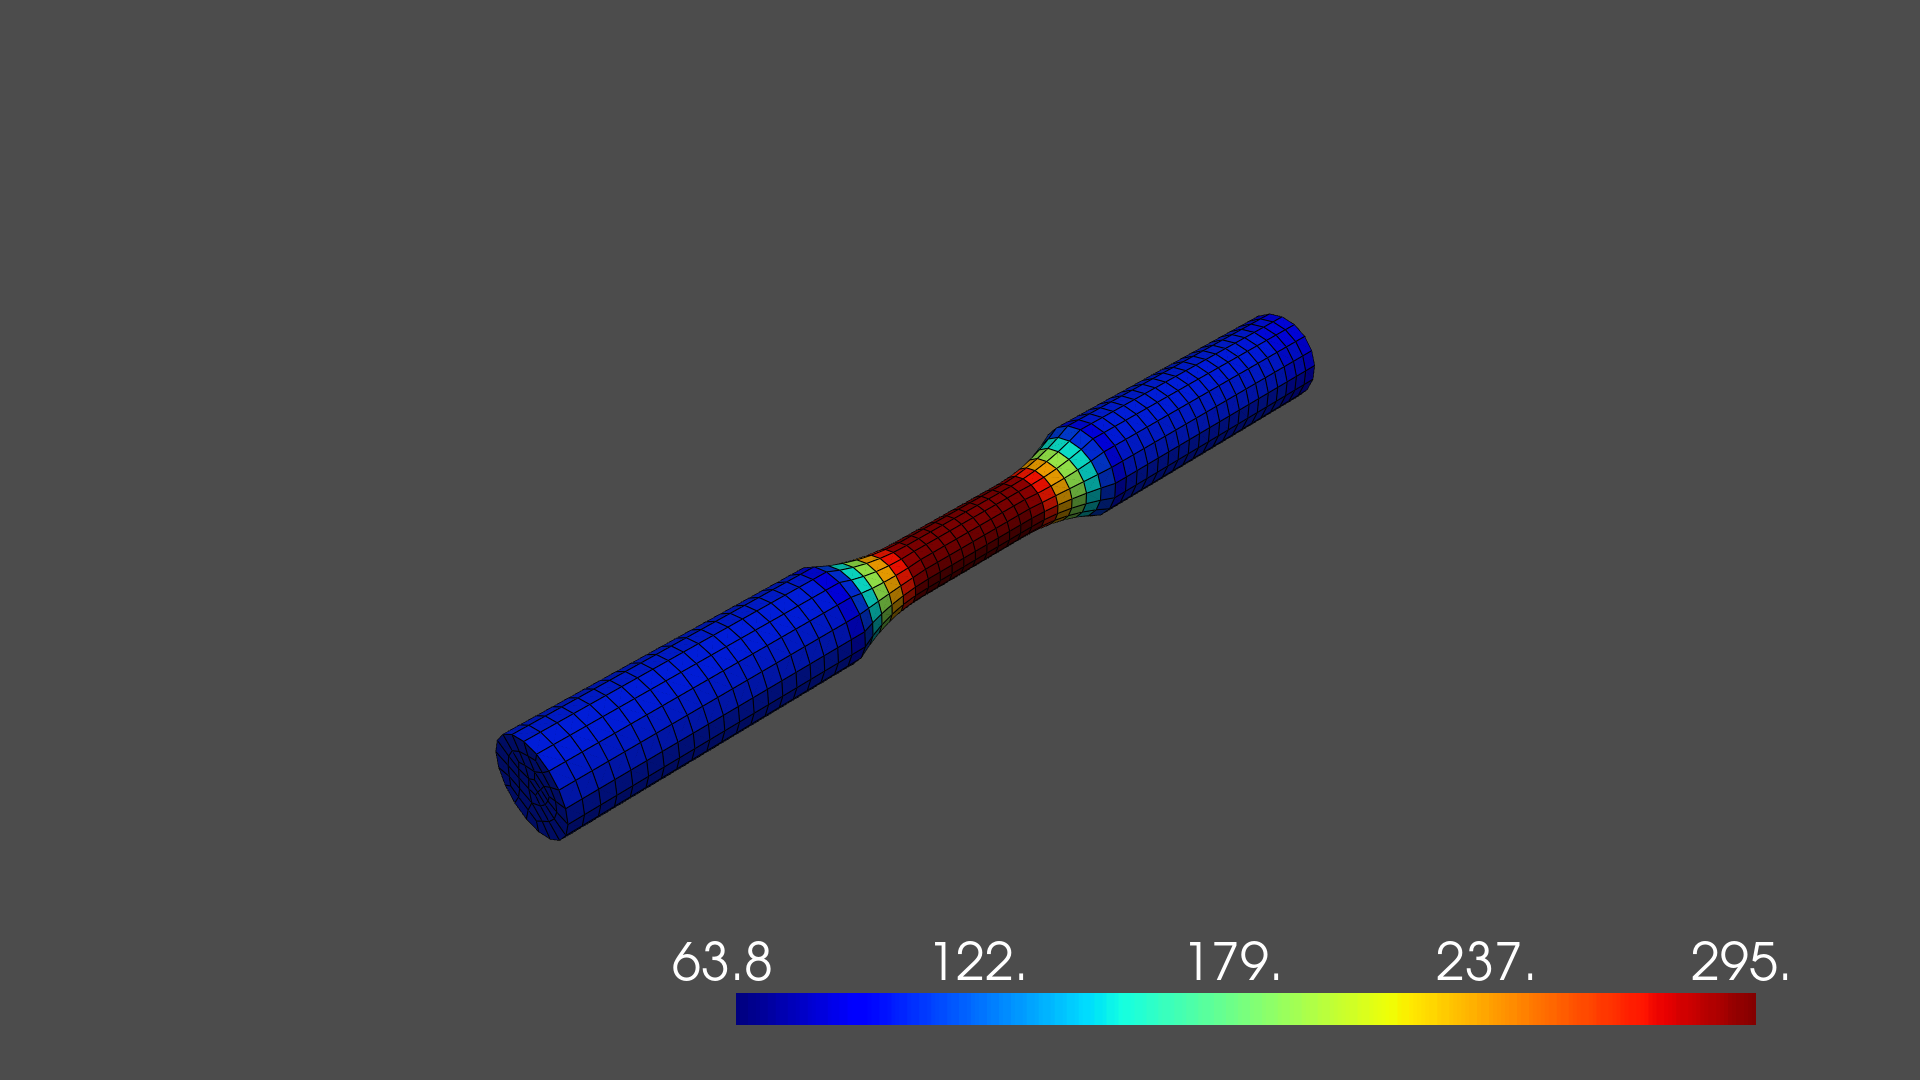

In [8]:
import pyvista as pv
grid = pv.UnstructuredGrid(*pylife_mesh.mesh.vtk_data())
plotter = pv.Plotter(window_size=[1920, 1080])
plotter.add_mesh(grid, scalars=pylife_mesh.groupby('element_id')['mises'].mean().to_numpy(),
                show_edges=True, cmap='jet')
plotter.add_scalar_bar()
plotter.show()